In [4]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from tqdm import tqdm

# ==== 路径设置 ====
data_dir = ""  # 请填入你的数据路径（包含train/val/test）
log_path = "log34.txt"
model_dir = "checkpoint_resnet34-2"
os.makedirs(model_dir, exist_ok=True)

# ==== 清空旧日志 ====
open(log_path, "w").close()

# ==== 日志函数 ====
def write_log(msg):
    timestamp = f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]"
    full_msg = f"{timestamp} {msg}"
    with open(log_path, "a") as f:
        f.write(full_msg + "\n")
    print(full_msg)

# ==== 数据预处理 ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ==== 加载并划分训练数据（使用四分之一） ====
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
targets = full_train_dataset.targets  # 所有图像的标签列表

# Stratified 方式选择四分之一数据
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
for train_idx, _ in sss.split(torch.zeros(len(targets)), targets):
    reduced_train_dataset = Subset(full_train_dataset, train_idx)

train_loader = DataLoader(reduced_train_dataset, batch_size=32, shuffle=True)

# ==== 加载验证集和测试集（完整） ====
val_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'val'), transform), batch_size=32, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'test'), transform), batch_size=32, shuffle=False)

class_names = full_train_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 初始化模型 ====
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==== 训练模型 ====
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    write_log(f"--- Epoch [{epoch+1}/{num_epochs}] ---")
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", ncols=100)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), acc=correct / total)

    acc = correct / total
    write_log(f"Epoch [{epoch+1}/{num_epochs}] Complete - Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

    if (epoch + 1) % 5 == 0:
        save_path = os.path.join(model_dir, f"resnet34_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), save_path)
        write_log(f"Saved model at {save_path}")

# ==== 测试函数 ====
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# ==== 测试模型 ====
accuracies = []
write_log("=== Evaluating Saved Models ===")
pth_files = sorted(glob.glob(os.path.join(model_dir, "*.pth")))
for path in pth_files:
    model.load_state_dict(torch.load(path))
    acc = evaluate_model(model, test_loader)
    accuracies.append(acc)
    write_log(f"{os.path.basename(path)} - Test Accuracy: {acc:.4f}")

# ==== 绘图 ====
plt.plot(range(5, 5 * len(accuracies) + 1, 5), accuracies, marker='o')
plt.title("Test Accuracy per Saved Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()


C:\Users\30419\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\30419\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[2025-04-28 18:46:05] --- Epoch [1/30] ---


Training Epoch 1: 100%|████████████████████████| 28/28 [00:08<00:00,  3.37it/s, acc=0.355, loss=1.3]


[2025-04-28 18:46:13] Epoch [1/30] Complete - Loss: 71.5102, Accuracy: 0.3549
[2025-04-28 18:46:13] --- Epoch [2/30] ---


Training Epoch 2:   4%|▉                          | 1/28 [00:00<00:05,  4.59it/s, acc=0.906, loss=1]


KeyboardInterrupt: 

[2025-04-28 18:31:19] --- Epoch [1/5] ---


Training Epoch 1: 100%|█████████████████████| 138/138 [00:36<00:00,  3.77it/s, acc=0.729, loss=1.02]


[2025-04-28 18:31:56] Epoch [1/5] Complete - Loss: 159.8672, Accuracy: 0.7292
[2025-04-28 18:31:56] --- Epoch [2/5] ---


Training Epoch 2: 100%|█████████████████████| 138/138 [00:36<00:00,  3.78it/s, acc=0.99, loss=0.109]


[2025-04-28 18:32:32] Epoch [2/5] Complete - Loss: 14.4851, Accuracy: 0.9898
[2025-04-28 18:32:32] --- Epoch [3/5] ---


Training Epoch 3: 100%|████████████████████| 138/138 [00:38<00:00,  3.62it/s, acc=0.995, loss=0.021]


[2025-04-28 18:33:10] Epoch [3/5] Complete - Loss: 5.2200, Accuracy: 0.9954
[2025-04-28 18:33:10] --- Epoch [4/5] ---


Training Epoch 4: 100%|███████████████████████| 138/138 [00:39<00:00,  3.51it/s, acc=1, loss=0.0653]


[2025-04-28 18:33:50] Epoch [4/5] Complete - Loss: 2.3258, Accuracy: 0.9995
[2025-04-28 18:33:50] --- Epoch [5/5] ---


Training Epoch 5: 100%|████████████████████| 138/138 [00:34<00:00,  3.98it/s, acc=0.998, loss=0.028]


[2025-04-28 18:34:24] Epoch [5/5] Complete - Loss: 2.2729, Accuracy: 0.9980
[2025-04-28 18:34:24] Saved model at ./check_improve_34-2\resnet34_epoch5.pth
[2025-04-28 18:34:24] === Evaluating Saved Models ===
[2025-04-28 18:34:38] resnet34_epoch5.pth - Test Accuracy: 0.8324


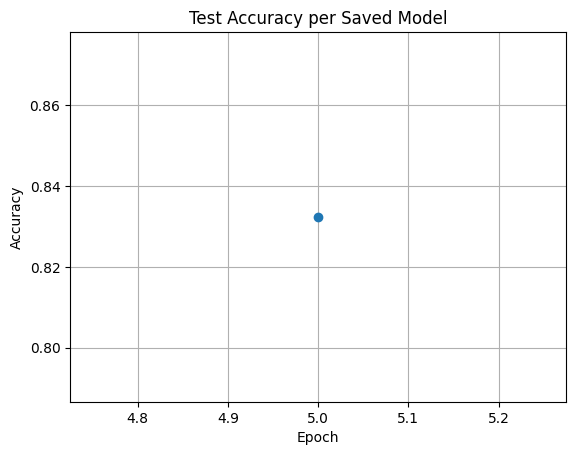

In [3]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from tqdm import tqdm  # 导入进度条

# ==== 路径设置 ====
data_dir = ""  # 请填入你的数据路径（包含train/val/test）
model_dir = "./check_improve_34-2"
os.makedirs(model_dir, exist_ok=True)

# ==== 清空旧日志 ====
open(log_path, "w").close()

# ==== 日志函数 ====
def write_log(msg):
    timestamp = f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]"
    full_msg = f"{timestamp} {msg}"
    with open(log_path, "a") as f:
        f.write(full_msg + "\n")
    print(full_msg)

# ==== 数据预处理 ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train_improve-2'), transform), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'val'), transform), batch_size=32, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'test'), transform), batch_size=32, shuffle=False)
class_names = train_loader.dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 初始化模型 ====
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==== 训练模型 ====
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    write_log(f"--- Epoch [{epoch+1}/{num_epochs}] ---")
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", ncols=100)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # 更新进度条显示信息
        progress_bar.set_postfix(loss=loss.item(), acc=correct / total)

    acc = correct / total
    write_log(f"Epoch [{epoch+1}/{num_epochs}] Complete - Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

    # 每5个epoch保存一次模型
    if (epoch + 1) % 5 == 0:
        save_path = os.path.join(model_dir, f"resnet34_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), save_path)
        write_log(f"Saved model at {save_path}")

# ==== 测试所有模型并记录准确率 ====
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# ==== 测试模型 ====
accuracies = []
write_log("=== Evaluating Saved Models ===")
pth_files = sorted(glob.glob(os.path.join(model_dir, "*.pth")))
for path in pth_files:
    model.load_state_dict(torch.load(path))
    acc = evaluate_model(model, test_loader)
    accuracies.append(acc)
    write_log(f"{os.path.basename(path)} - Test Accuracy: {acc:.4f}")

# ==== 绘制准确率曲线 ====
plt.plot(range(5, 5 * len(accuracies) + 1, 5), accuracies, marker='o')
plt.title("Test Accuracy per Saved Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()
